## Which of the London Boroughs has an increasing and which has a decreasing amount of crime events?  

In [1]:
import os
import numpy as np;
import pandas as pd
from pandas.io import gbq
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
%matplotlib inline

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "deeplearning-97d854aac156.json"
# Instantiates a client

bigquery_client = bigquery.Client()
QUERY ="""
SELECT year, borough, sum(value) as number 
FROM  `bigquery-public-data.london_crime.crime_by_lsoa`
group by borough ,year
order by borough,year DESC; 
"""

df = gbq.read_gbq(QUERY, dialect='standard' );

/home/enzo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/enzo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/enzo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/enzo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/enzo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### The metric used to define whether the crime events  are increasing or decreasing is the linear regression coefficient of number of crimes over the years.
If positive it is increasing, if negative it is decreasing.

The absolute value of the coefficient defines the magnitude of the increasing/decreasing. 

### Let 's first check the coefficient for the whole London 

To compare the linear coefficients for the different sets we need to standardize the data.
Otherwise, a borough with major number of events would have different weight than a borough with less events.


In [2]:
mio = df.copy()
mio = mio.groupby('year').sum()
mio = mio.sort_values(['year'])

mio['year'] = mio.index
val_max = mio.number.max()
val_min = mio.number.min()

# standardization
mio['number_st'] = (mio.number-val_min)/(val_max-val_min)

regr = linear_model.LinearRegression()
regr.fit(mio[['year']],mio.number_st)
print("The Linear Coefficient for the whole London between 2008 to 2016 is {:.2f}".format(regr.coef_[0]))  

The Linear Coefficient for the whole London between 2008 to 2016 is -0.04


The coefficient is negative, but very close to zero.
Let's see the charts:

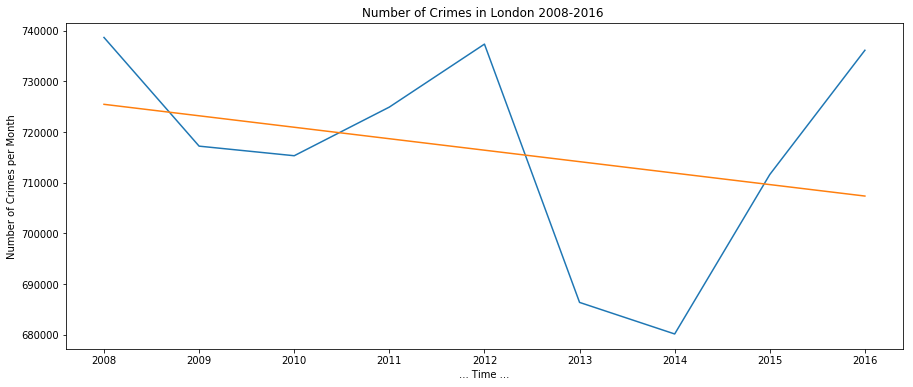

In [3]:
regr.fit(mio[['year']],mio.number)
y_est=regr.predict(mio[['year']])
mio.number.plot(figsize=(15, 6))
plt.plot(mio[['year']],y_est)
plt.title('Number of Crimes in London 2008-2016 ')
plt.ylabel('Number of Crimes per Month')
plt.xlabel('... Time ...')
plt.show()

From the chart we can see that the trend is negative, mainly because of the years 2013 and 2014.
2016 has a similar number of events as the initial period of 2008.

### Let's check the trend for each Borough.

In [4]:
borough=list(set(df['borough']))
bor_crime = dict()
min_reg=9
min_item=""
max_reg=0
max_item=""

for bor in borough:
    temp=df[df['borough'] == bor];
    X=temp[['year']]
    val_max = temp.number.max()
    val_min = temp.number.min()
    temp['number']=(temp.number-val_min)/(val_max-val_min);
    
    
    regr = linear_model.LinearRegression()
    regr.fit(X, temp.number.values)
    bor_crime[bor] = regr.coef_
    if regr.coef_ > max_reg:
        max_reg = regr.coef_
        max_item = bor
    if regr.coef_ < min_reg:
        min_reg = regr.coef_
        min_item = bor;
        
print(" The coef max is {:.2f}, for the borough {}".format(max_reg[0], max_item))
print(" The coef min is {:.2f}, for the borough {}".format(min_reg[0], min_item))

/home/enzo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


 The coef max is 0.13, for the borough City of London
 The coef min is -0.13, for the borough Waltham Forest


In [5]:
mio_dataset=pd.DataFrame.from_dict(bor_crime, orient='index',columns=['coef_regr'])
mio_dataset.sort_values('coef_regr')

,coef_regr
Waltham Forest,-0.130991
Sutton,-0.105423
Merton,-0.104496
Harrow,-0.093870
Barking and Dagenham,-0.088150
Croydon,-0.086623
Redbridge,-0.084108
Bexley,-0.082253
Ealing,-0.080367
Camden,-0.080019


### Let's see how they are distributed

Mean -0.01977127417877507
Median -0.03305408920511056


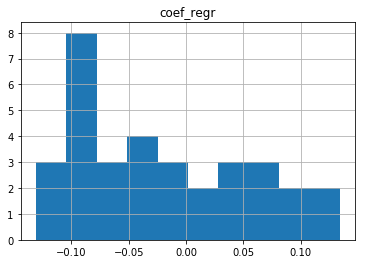

In [6]:
mio_dataset.hist();
print("Mean {}".format(mio_dataset.coef_regr.mean()))
print("Median {}".format(mio_dataset.coef_regr.median()))

According to the distribution most of the Boroughs have a decreasing number of crimes.

### Just out of curiosity... let's find the Borough with most crimes decrease and the one with most crimes increase. 

#### The charts of the borough with most crimes decrease (with the real value).

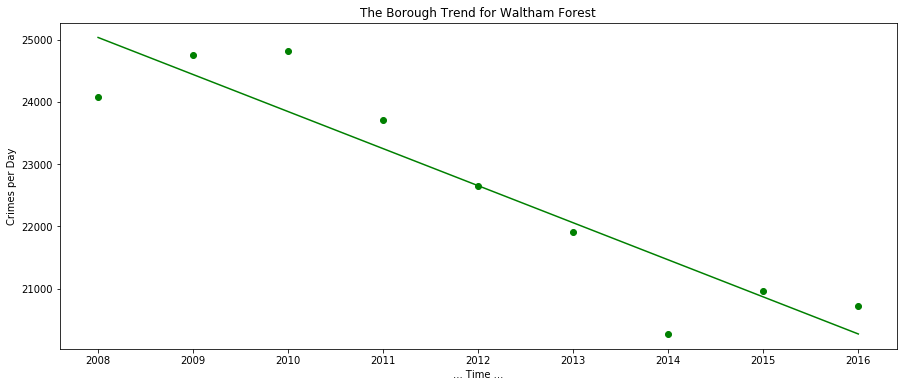

In [7]:
tempmin=df[df['borough'] == min_item]

regrmin = linear_model.LinearRegression()
regrmin.fit(X, tempmin.number.values)
y_minPredict=regrmin.predict(mio[['year']])

X=tempmin[['year']]

plt.figure(figsize=(15, 6))
plt.scatter(X,tempmin.number.values, color='green')    
plt.plot(mio[['year']],y_minPredict,color='green')
plt.xlabel('... Time ...')
plt.ylabel("Crimes per Day")
plt.title("The Borough Trend for {}".format(min_item));

From the year 2008 to the year 2016  the number of Crimes in Waltham Forest decreased of more of four thousands.

### The chart of the Borough with most crimes increase (with the real value).

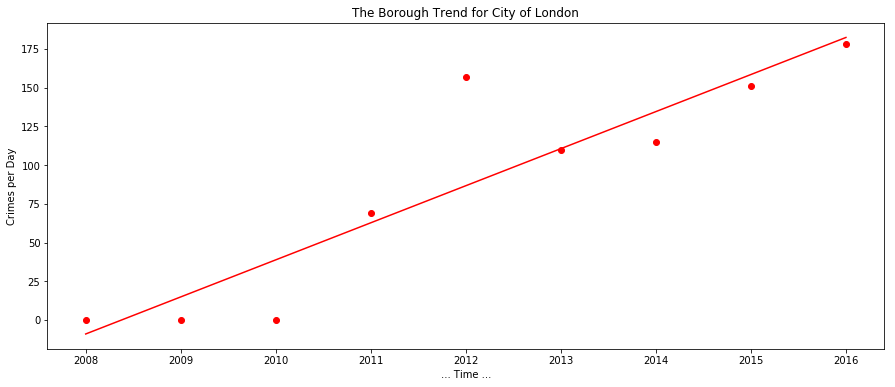

In [8]:
tempmax=df[df['borough'] == max_item]

regrmax = linear_model.LinearRegression()
regrmax.fit(X, tempmax.number.values)
y_maxPredict=regrmax.predict(mio[['year']])

X=tempmax[['year']]

plt.figure(figsize=(15, 6))
plt.scatter(X,tempmax.number.values, color='red')    
plt.plot(mio[['year']],y_maxPredict,color='red')
plt.xlabel('... Time ...')
plt.ylabel("Crimes per Day")
plt.title("The Borough Trend for {}".format(max_item));

The number increased from zero to 175, it is an increase, but we should check if something was changing on how the crimes were registered between 2010 and 2011.

### Summary:

Overall, the number of crimes in London is decreasing, there are few boroughs where the number is increasing.
The good news is that for those like City of London, the global number is relatively small, therefore even if increasing the effect is not so dramatic.